# **FGV EESP**

- ## VAR e VECM - Expectativa de Inflação do Mercado
---



### **Bibliotecas**

In [ ]:
# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

# Função tidy()
install.packages("broom")

In [ ]:
library(broom)
library(dplyr)
library(ggplot2)
library(httr)
library(lubridate)
library(readxl)
library(tsDyn)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [3]:
# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/public_data.xlsx"

# Download do arquivo
download.file(file_path, "public_data.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_public_data <- as.data.frame(read_excel("public_data.xlsx"))

# Converter year e month_name
df_public_data <- df_public_data %>%
  mutate(year = as.numeric(year),  # Converter year para numérico
         month_name = factor(month_name, levels = month.abb, ordered = TRUE))  # Converter month_name para um fator ordenado

# Converter month_date
df_public_data$month_date <- ymd(df_public_data$month_date)  # Converter month_date para formato Date

# Lista de variáveis para transformar em séries temporais
vars_to_convert <- c("month", "market_inflation_expectation", "consumer_inflation_expectation", "consumer_confidence_index", "inflation_target", "inflation_target_lower_bound", "inflation_target_upper_bound", "inflation_target_wtd_avg", "inflation_target_lower_bound_wtd_avg", "inflation_target_upper_bound_wtd_avg", "ipca", "selic", "selic_deflated", "minimum_wage_increase", "minimum_wage_increase_deflated", "income_increase", "income_increase_deflated", "household_income_deflated", "household_income_deflated_trend", "household_income_deflated_trend_diff", "real_exchange_rate", "real_exchange_rate_trend", "real_exchange_rate_trend_diff", "pib", "primary_fiscal_result", "primary_fiscal_result_pct_pib", "ipca_lag", "selic_deflated_lag", "primary_fiscal_result_pct_pib_lag", "real_exchange_rate_trend_diff_lag", "household_income_deflated_trend_diff_lag", "consumer_confidence_index_lag")

# Loop para transformar as variáveis em séries temporais
for (var in vars_to_convert) {
  df_public_data[[var]] <- ts(df_public_data[[var]], start = c(2006, 1), frequency = 12)
}

In [4]:
str(df_public_data)

'data.frame':	212 obs. of  35 variables:
 $ year                                    : num  2006 2006 2006 2006 2006 ...
 $ month_name                              : Ord.factor w/ 12 levels "Jan"<"Feb"<"Mar"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ month_date                              : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                                   : Time-Series  from 2006 to 2024: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation            : Time-Series  from 2006 to 2024: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation          : Time-Series  from 2006 to 2024: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ consumer_confidence_index               : Time-Series  from 2006 to 2024: 93.3 92.8 93 91.8 90.7 90.7 91.2 91.8 91.5 94.3 ...
 $ inflation_target                        : Time-Series  from 2006 to 2024: 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 ...
 $ inflation_target_lower_bound            : Time-Series  from 2006 to

### **Modelo VAR**

In [5]:
# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca", "inflation_target_wtd_avg", "primary_fiscal_result_pct_pib", "selic_deflated", "real_exchange_rate_trend_diff", "household_income_deflated_trend_diff")]

In [6]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      3      2      5 


In [7]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "none")

tidy(var_model)

group,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_inflation_expectation,market_inflation_expectation.l1,1.160068485,0.073289253,15.8286302,6.812391e-37
market_inflation_expectation,ipca.l1,0.079719349,0.054303810,1.4680250,1.437004e-01
market_inflation_expectation,inflation_target_wtd_avg.l1,2.245070945,3.187566448,0.7043213,4.820687e-01
market_inflation_expectation,primary_fiscal_result_pct_pib.l1,-1.269882737,2.082689013,-0.6097323,5.427454e-01
market_inflation_expectation,selic_deflated.l1,0.097840766,0.050259548,1.9467100,5.299867e-02
market_inflation_expectation,real_exchange_rate_trend_diff.l1,0.007405385,0.004243658,1.7450474,8.254389e-02
market_inflation_expectation,household_income_deflated_trend_diff.l1,0.095964369,0.058148103,1.6503439,1.004741e-01
market_inflation_expectation,market_inflation_expectation.l2,-0.276591150,0.074072971,-3.7340361,2.469335e-04
market_inflation_expectation,ipca.l2,-0.045277556,0.057098557,-0.7929720,4.287530e-01


In [8]:
summary(var_model)


VAR Estimation Results:
Endogenous variables: market_inflation_expectation, ipca, inflation_target_wtd_avg, primary_fiscal_result_pct_pib, selic_deflated, real_exchange_rate_trend_diff, household_income_deflated_trend_diff 
Deterministic variables: none 
Sample size: 210 
Log Likelihood: 1482.844 
Roots of the characteristic polynomial:
1.005 1.001 0.974 0.974  0.97  0.97 0.7829 0.7582 0.7582 0.6765 0.6765 0.2793 0.1826 0.05224
Call:
VAR(y = var_model_variables, p = 2, type = "none")


Estimation results for equation market_inflation_expectation: 
market_inflation_expectation = market_inflation_expectation.l1 + ipca.l1 + inflation_target_wtd_avg.l1 + primary_fiscal_result_pct_pib.l1 + selic_deflated.l1 + real_exchange_rate_trend_diff.l1 + household_income_deflated_trend_diff.l1 + market_inflation_expectation.l2 + ipca.l2 + inflation_target_wtd_avg.l2 + primary_fiscal_result_pct_pib.l2 + selic_deflated.l2 + real_exchange_rate_trend_diff.l2 + household_income_deflated_trend_diff.l2 

  

In [9]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 998.45, df = 490, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 998.45, df = 490, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [10]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5544, df = 9408, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5544, df = 9408, p-value = 1



**Resultado**

- Como o p-value é **maior** que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [11]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2424.8, df = 14, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 227.8, df = 7, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2197, df = 7, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2424.8, df = 14, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 227.8, df = 7, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2197, df = 7, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

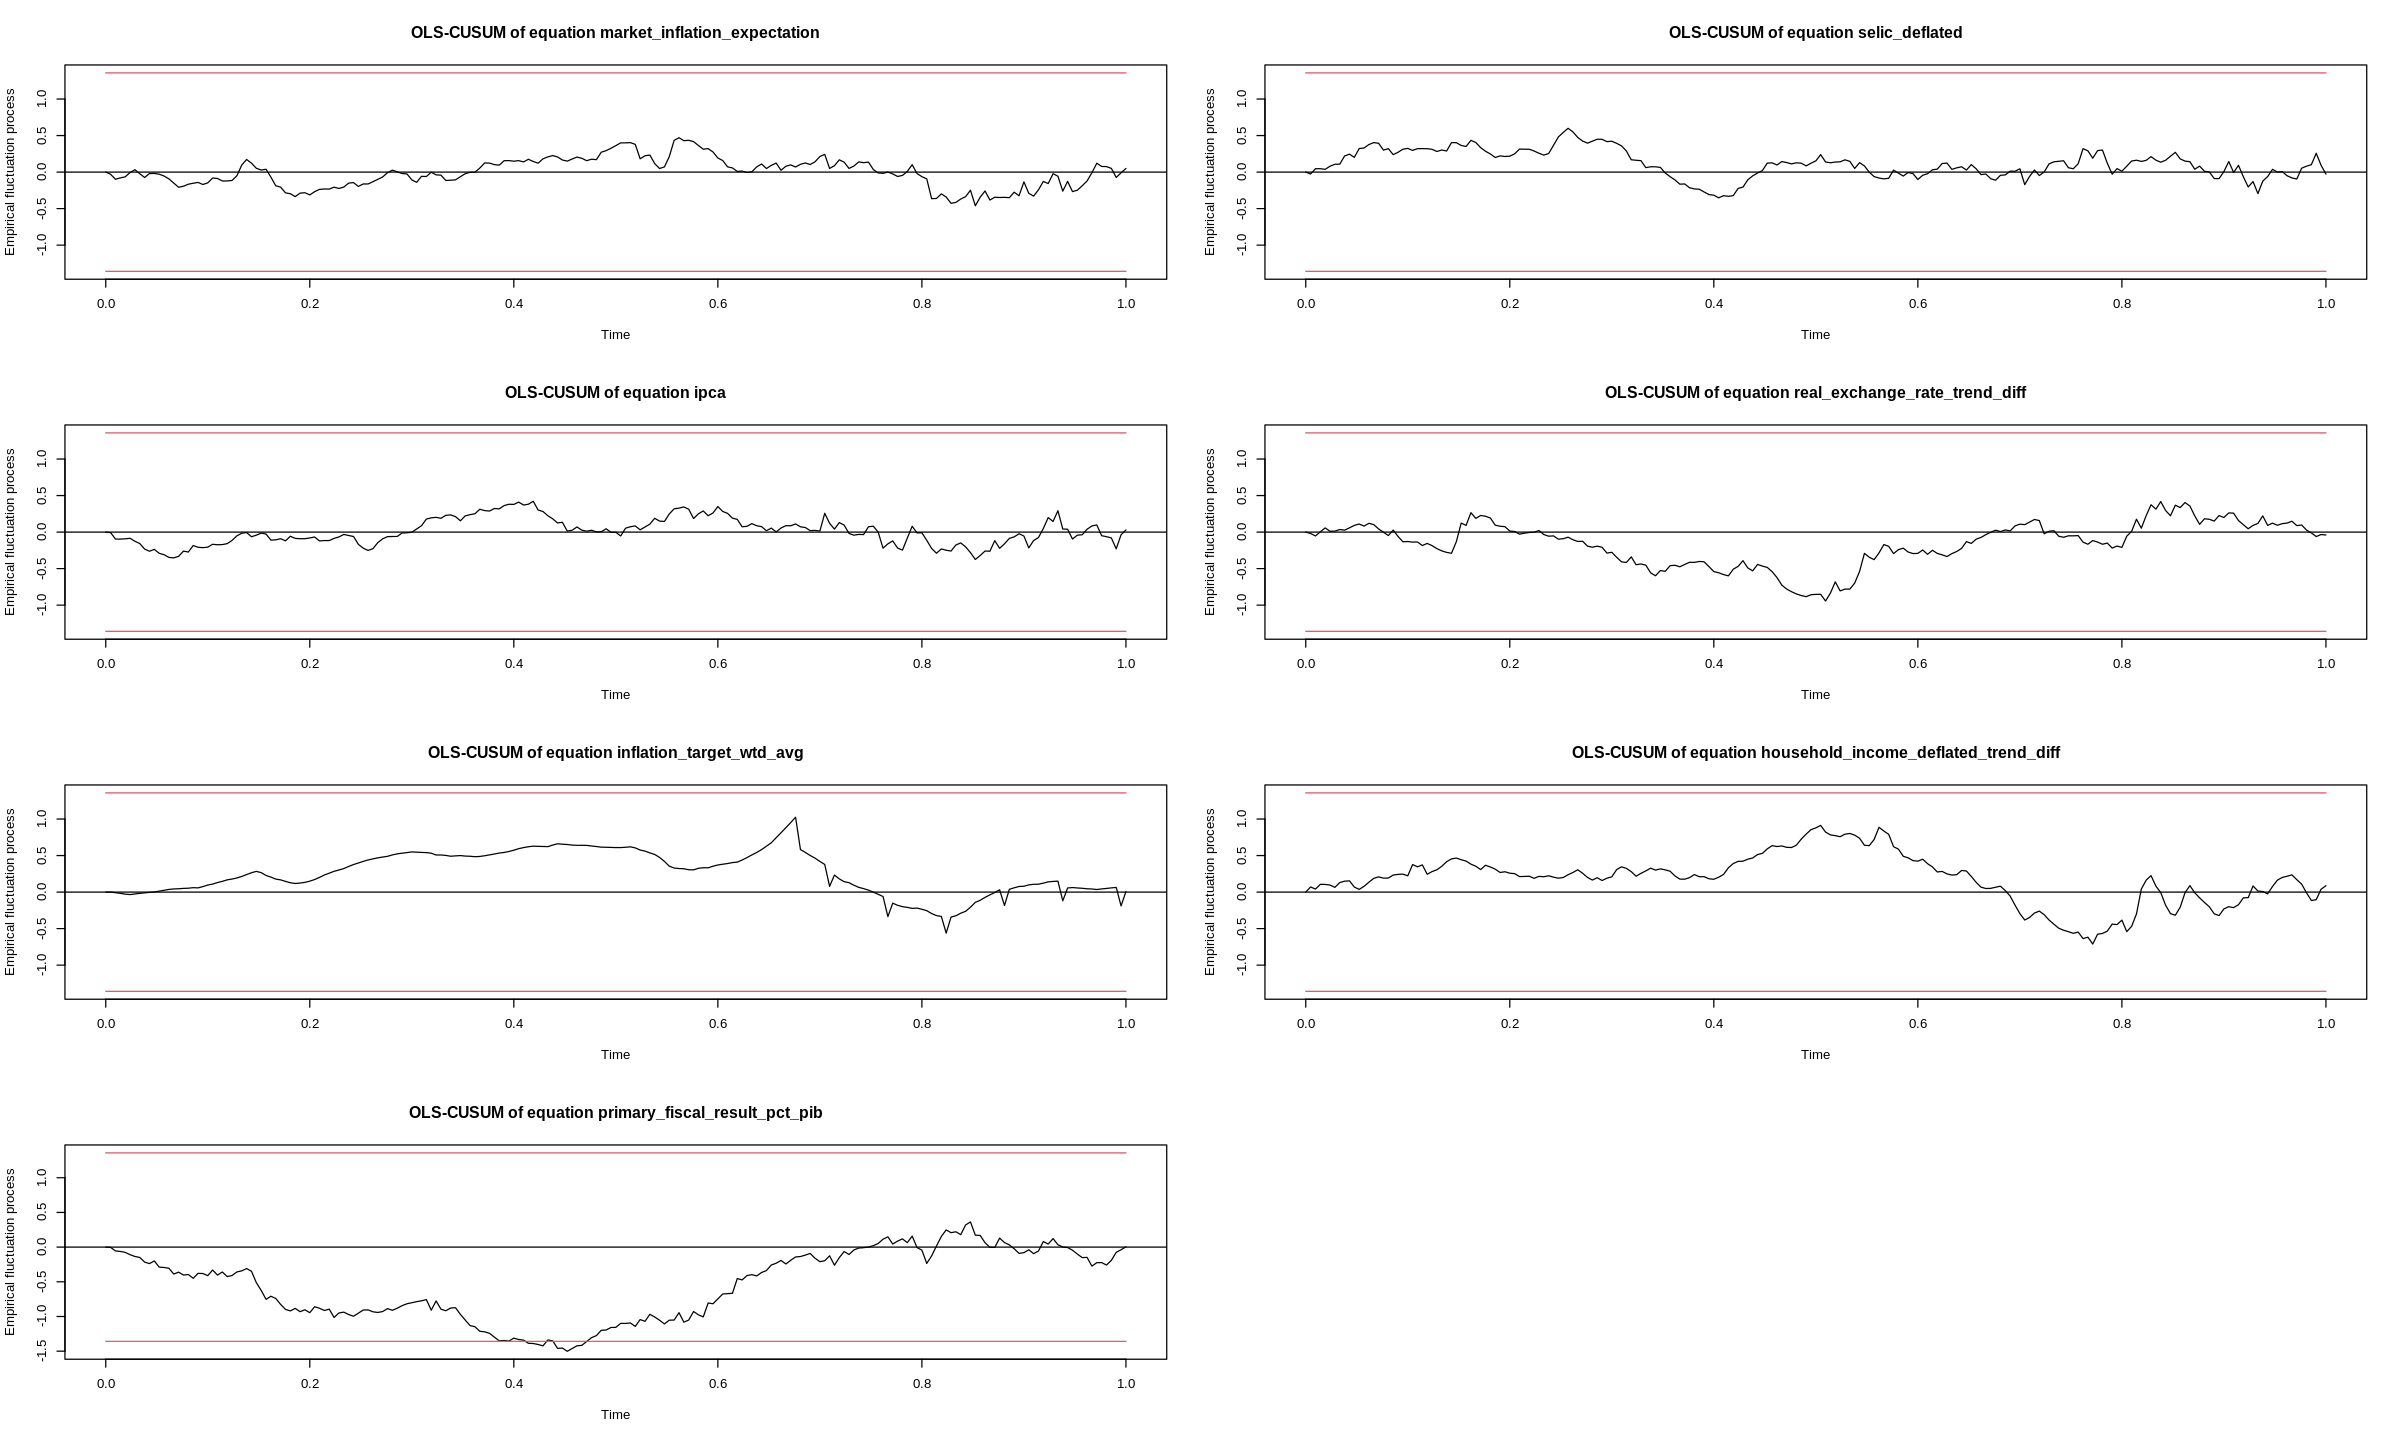

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 12)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, com exceção da variável relacionada ao resultado fiscal, pode-se afirmar que não há quebra estrutural nos resíduos

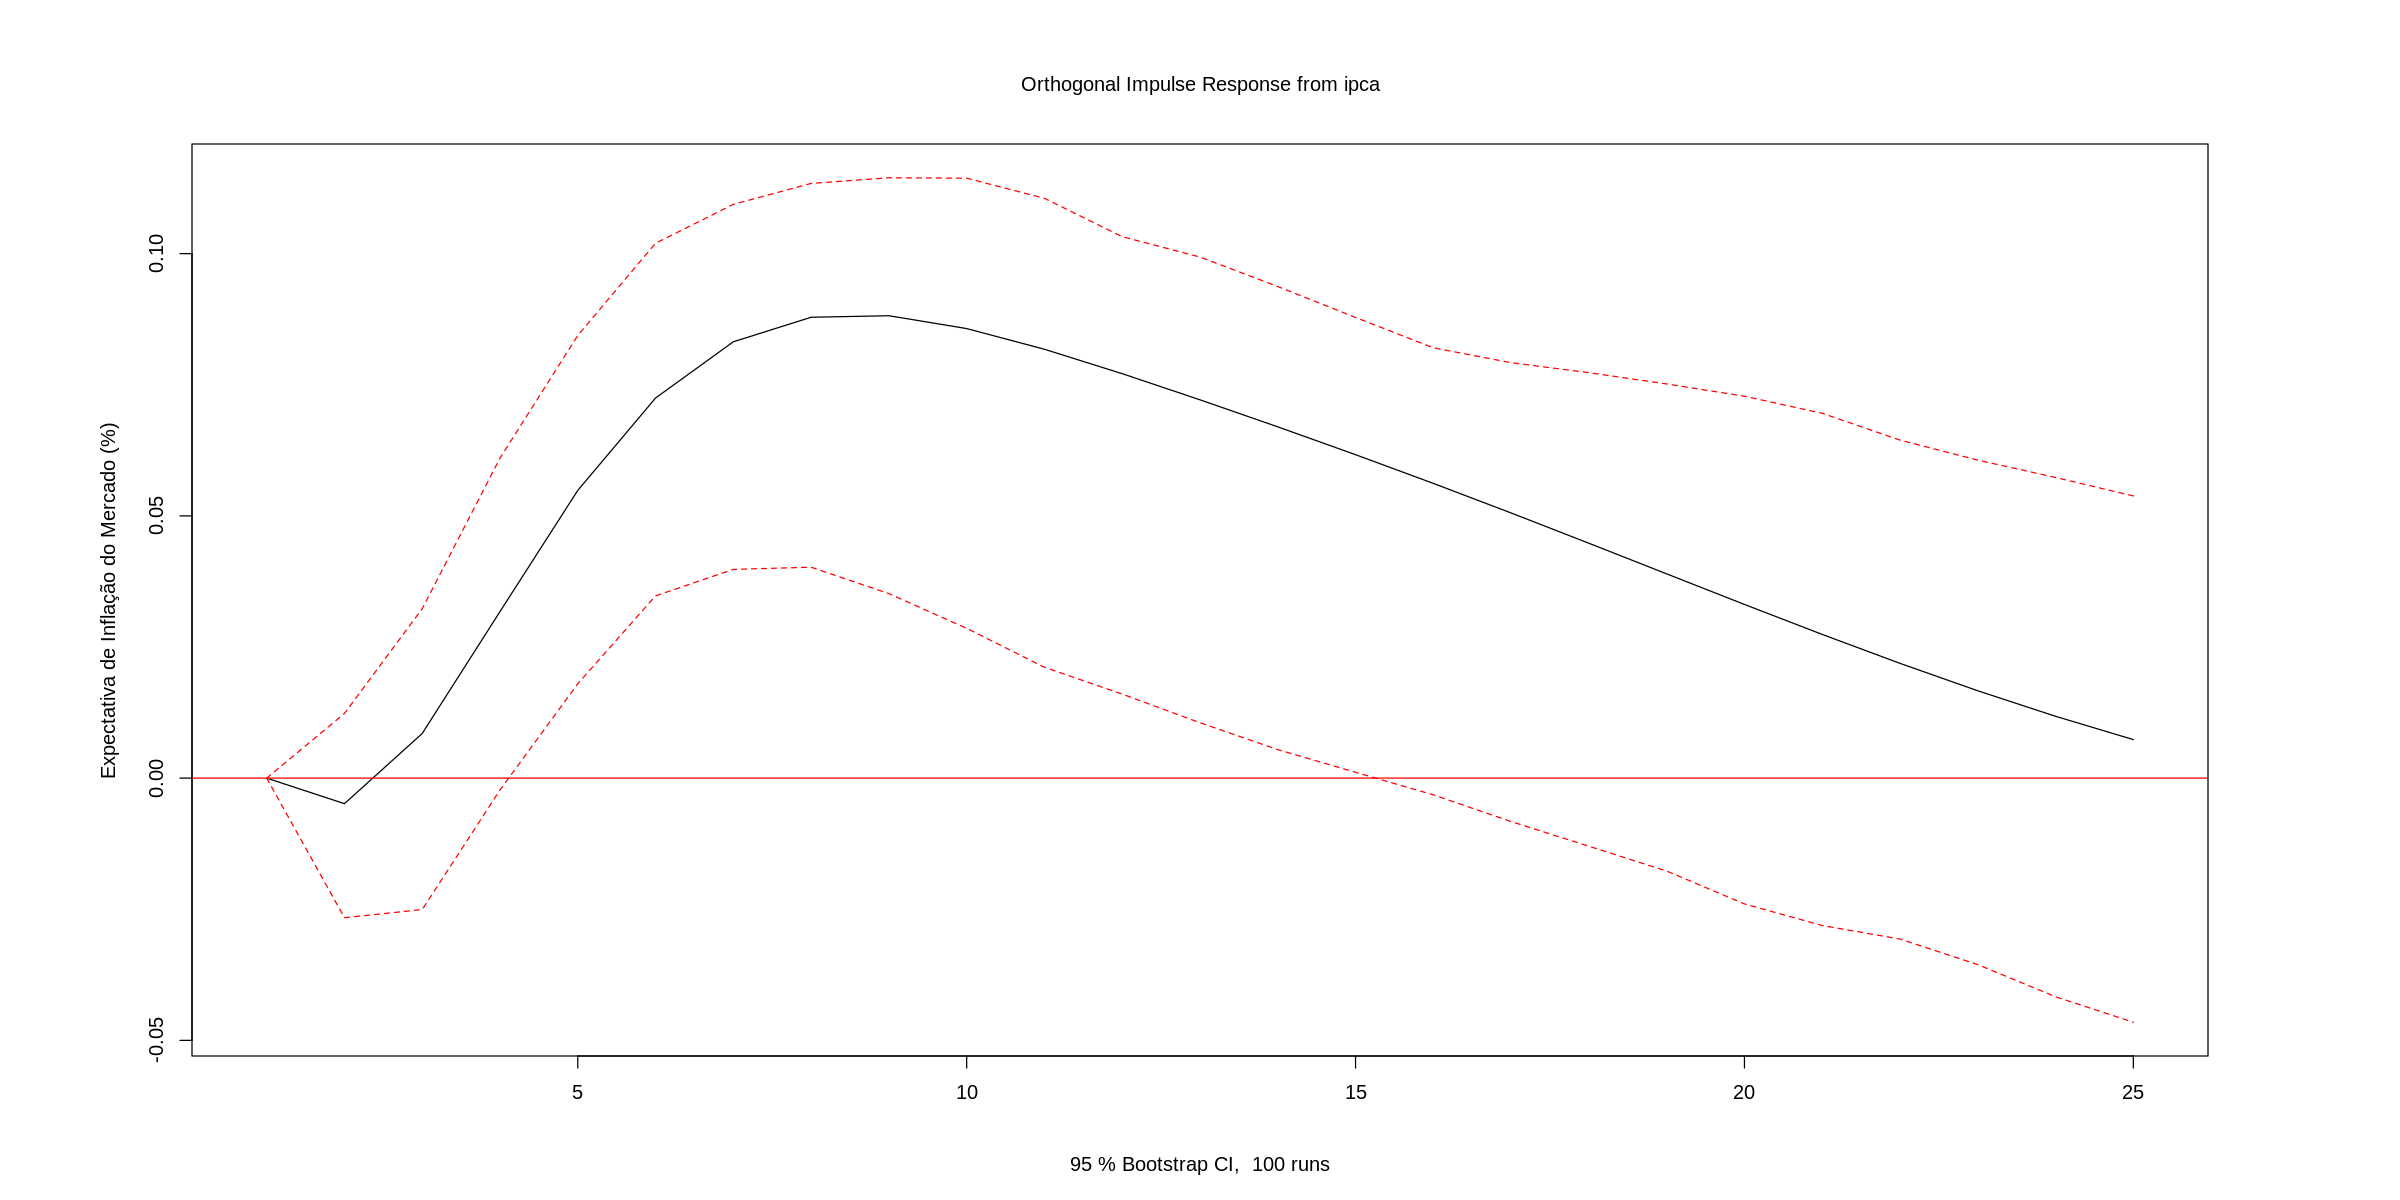

In [13]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Impulse Response Function
market_expectation_impulse = irf(var_model, impulse = "ipca", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)")

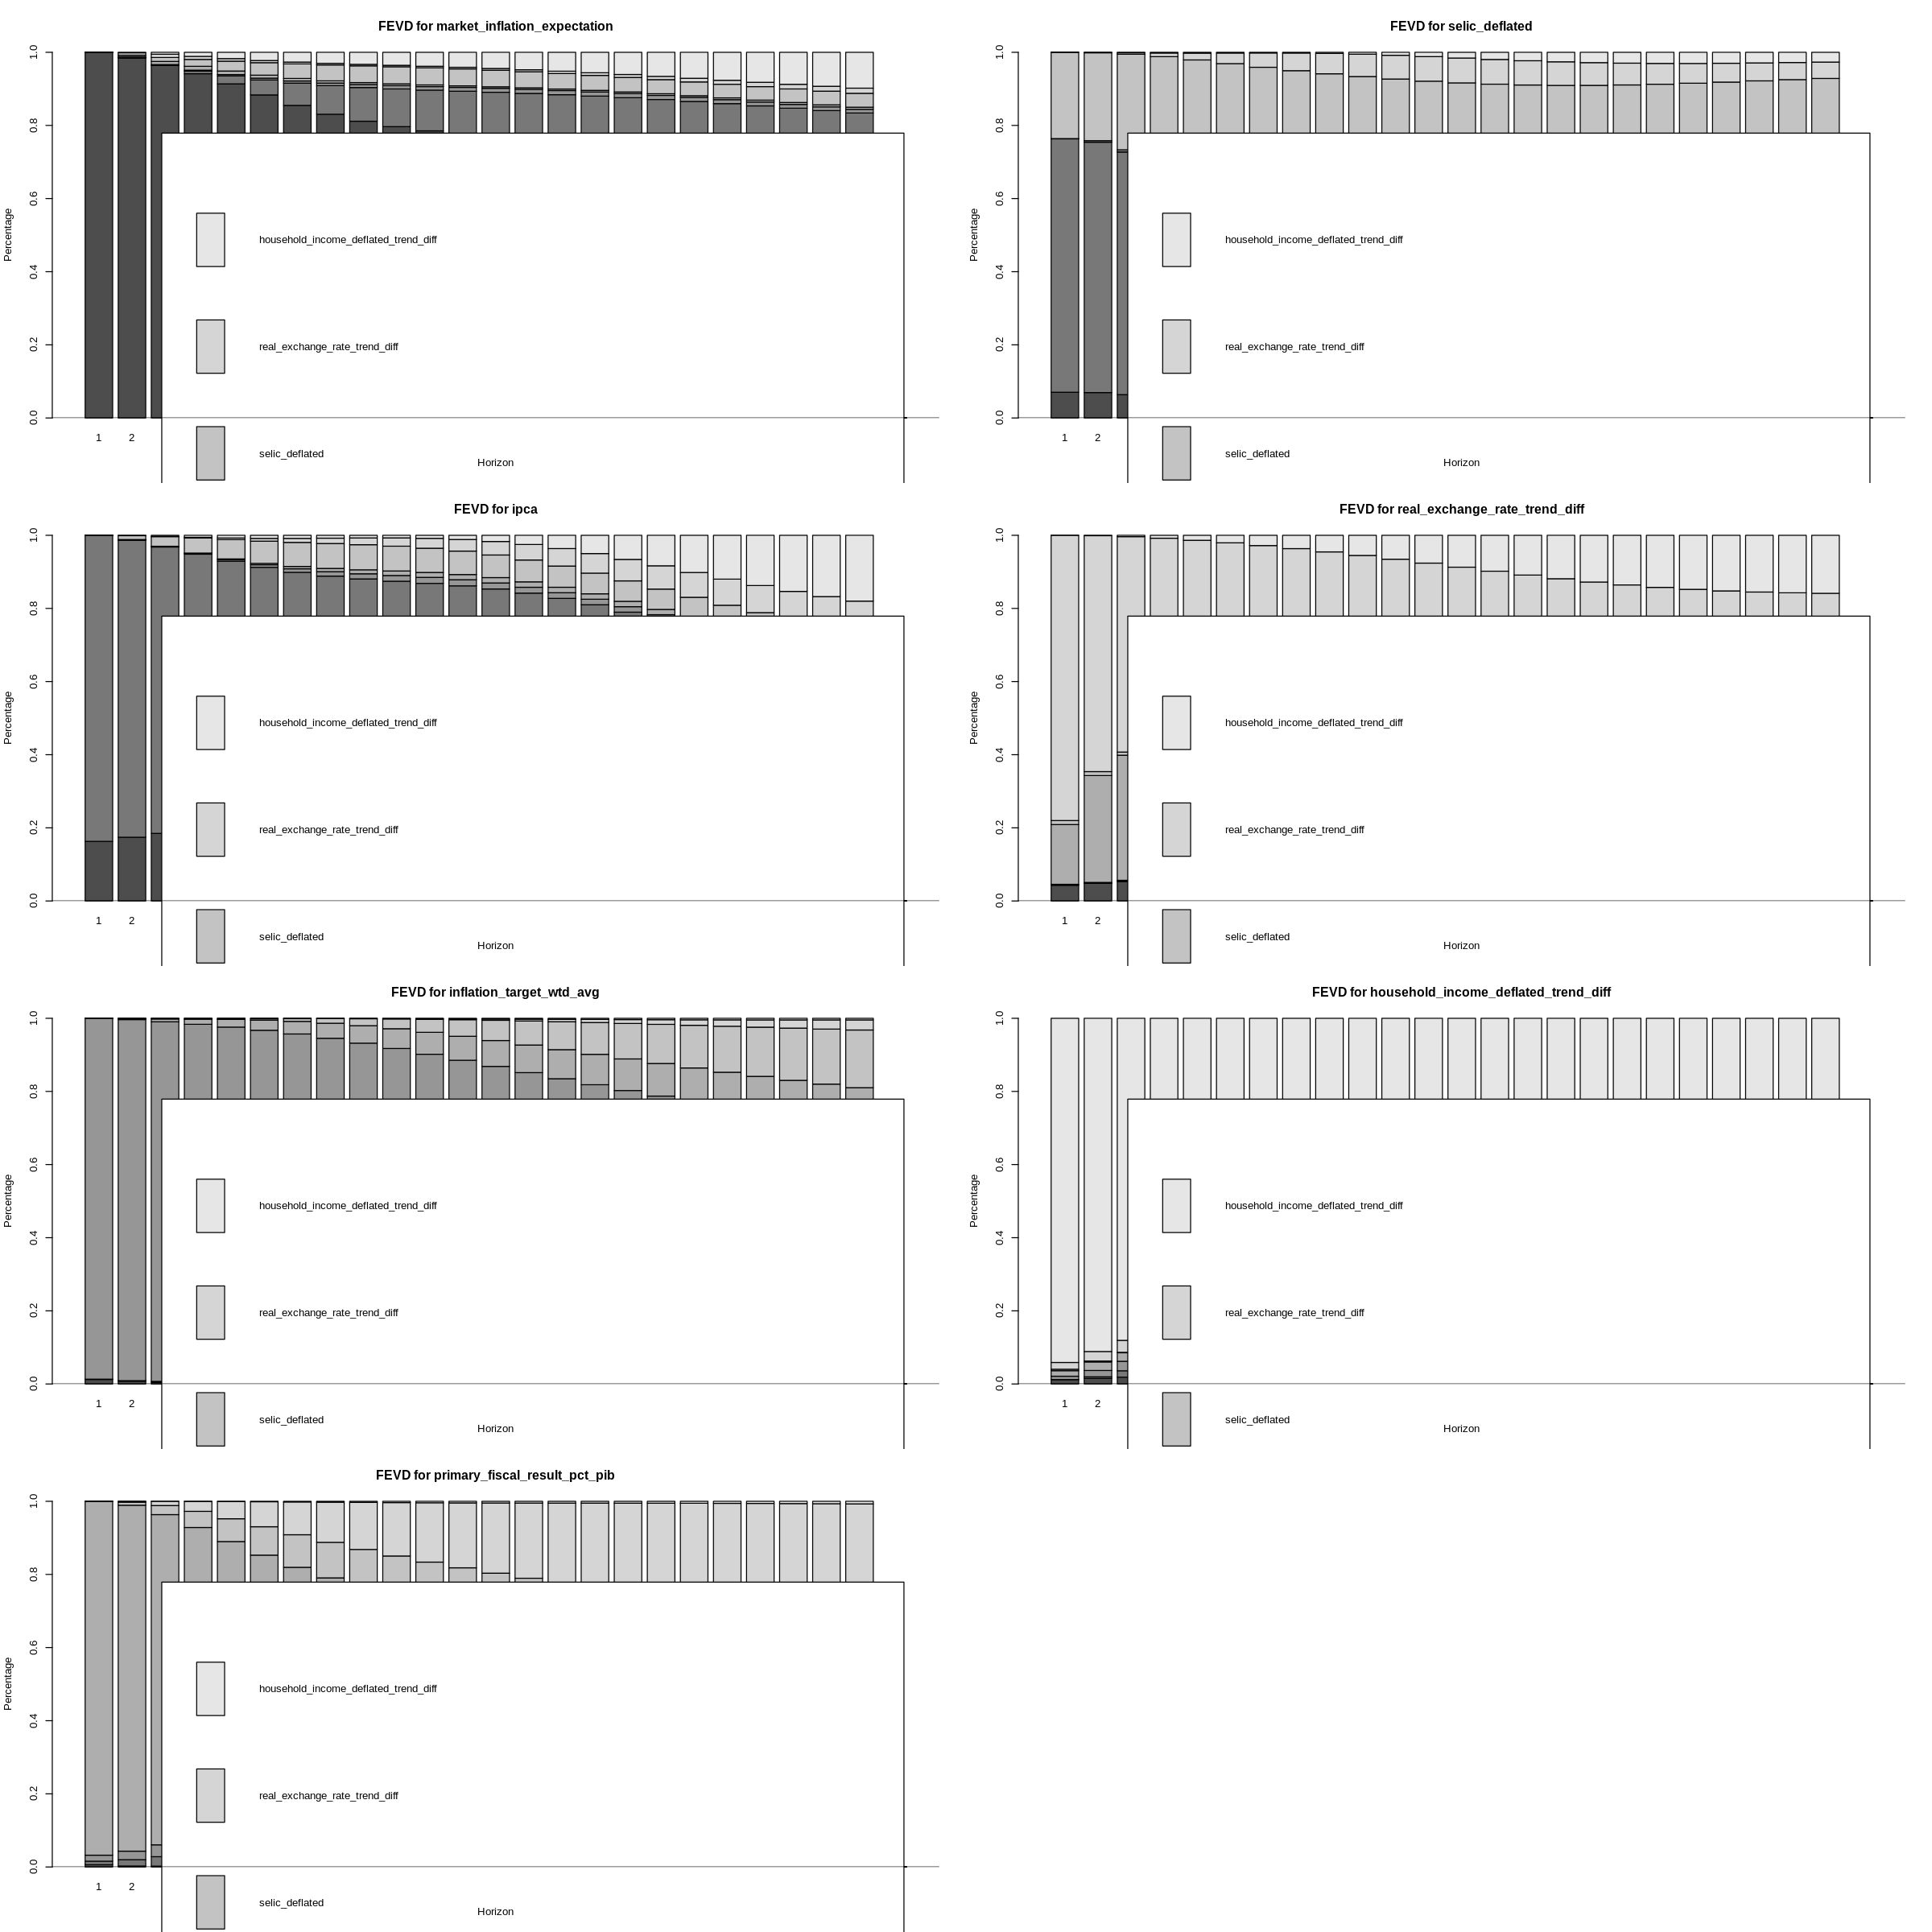

In [14]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 20)

# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

plot(fevd_model)

**Resultado**

-

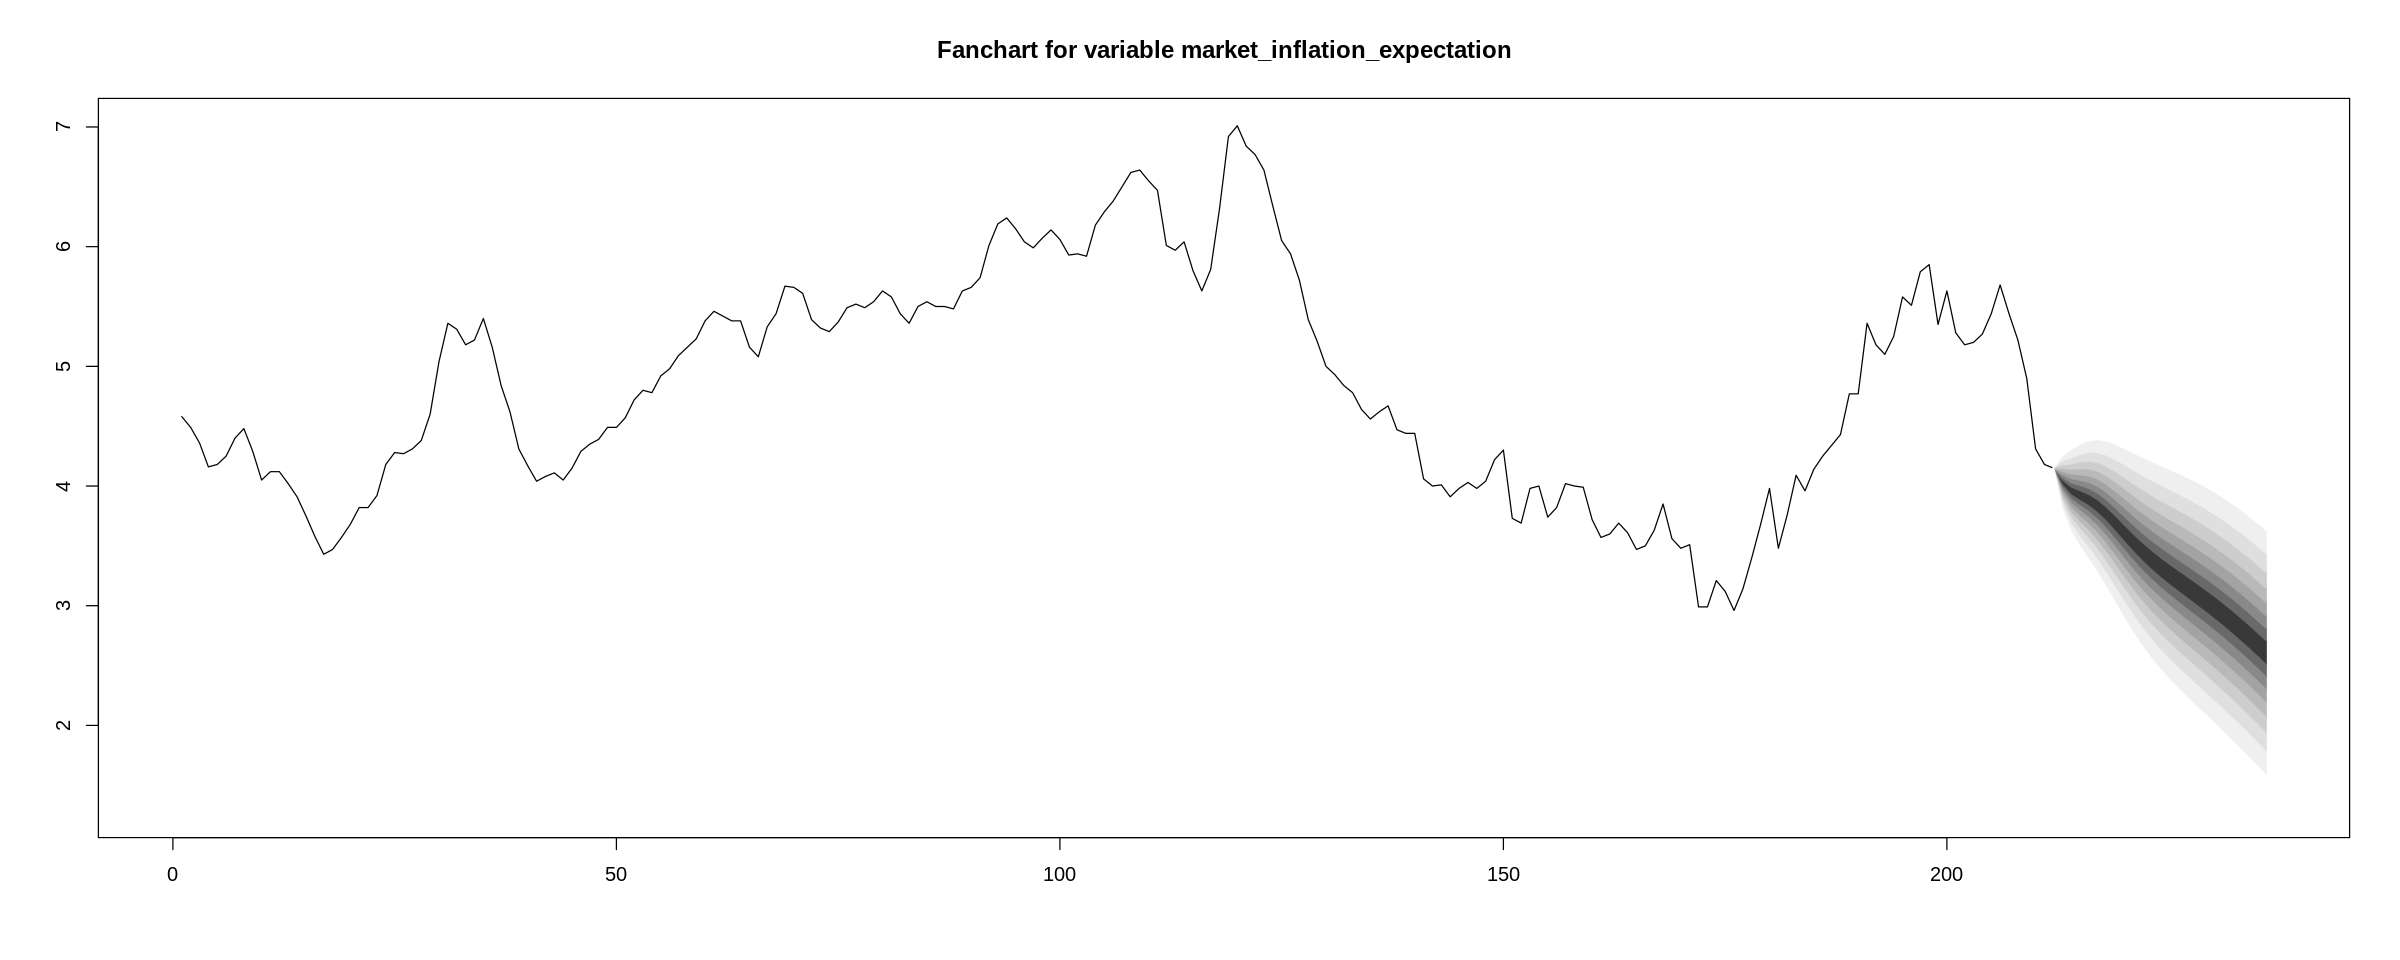

In [15]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 8)

# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

fanchart(forecast_var, names = "market_inflation_expectation")

### **Modelo VECM**

In [16]:
# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca", "inflation_target_wtd_avg", "primary_fiscal_result_pct_pib", "selic_deflated", "real_exchange_rate_trend_diff", "household_income_deflated_trend_diff")]

In [17]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "none")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     5      3      2      5 


In [18]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "none", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 3.116637e-01 1.897609e-01 1.524040e-01 1.359668e-01 8.878276e-02
[6] 4.917785e-02 1.217518e-05

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 6 |   0.00   6.50   8.18  11.65
r <= 5 |  10.59  15.66  17.95  23.52
r <= 4 |  30.12  28.71  31.52  37.22
r <= 3 |  60.81  45.23  48.28  55.43
r <= 2 |  95.53  66.49  70.60  78.87
r <= 1 | 139.72  85.18  90.39 104.20
r = 0  | 218.15 118.99 124.25 136.06

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                        market_inflation_expectation.l2
market_inflation_expectation.l2                              1.00000000
ipca.l2                                                     -1.09841971
inflation_target_wtd_avg.l2                                 -6.57805027
primary_fiscal_result_pct_pib.l2 

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 2 relações de cointegração no sistema

- r <= 2: Como teststatistic é maior que critical value a um nível de significância de 20%, rejeita-se a hipótese nula, ou seja, existe ao menos 3 relações de cointegração no sistema

- r <= 3: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 4 relações de cointegração no sistema

- r <= 4: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 4 relações de cointegração no sistema

In [19]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "none", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 3.116637e-01 1.897609e-01 1.524040e-01 1.359668e-01 8.878276e-02
[6] 4.917785e-02 1.217518e-05

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 6 |  0.00  6.50  8.18 11.65
r <= 5 | 10.59 12.91 14.90 19.19
r <= 4 | 19.52 18.90 21.07 25.75
r <= 3 | 30.69 24.78 27.14 32.14
r <= 2 | 34.72 30.84 33.32 38.78
r <= 1 | 44.19 36.25 39.43 44.59
r = 0  | 78.43 42.06 44.91 51.30

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                        market_inflation_expectation.l2
market_inflation_expectation.l2                              1.00000000
ipca.l2                                                     -1.09841971
inflation_target_wtd_avg.l2                                 -6.57805027
primary_fiscal_result_pct_pib.l2       

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 2 relações de cointegração no sistema

- r <= 2: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 3 relações de cointegração no sistema

- r <= 3: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 4 relações de cointegração no sistema

- r <= 4: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 4 relações de cointegração no sistema

In [20]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 2, r = 5, estim = ("ML"))

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 212 	End sample size: 209
Number of variables: 7 	Number of estimated slope parameters 140
AIC -7002.832 	BIC -6501.482 	SSR 1812.491
Cointegrating vector (estimated by ML):
   market_inflation_expectation          ipca inflation_target_wtd_avg
r1                 1.000000e+00  2.131390e-16             4.467453e-16
r2                 5.495768e-17  1.000000e+00             2.557038e-16
r3                 4.766541e-16 -2.600475e-16             1.000000e+00
r4                -1.938191e-17 -3.199626e-17             6.314730e-18
r5                -5.725421e-15  1.569521e-15             1.022106e-15
   primary_fiscal_result_pct_pib selic_deflated real_exchange_rate_trend_diff
r1                  2.361595e-16   0.000000e+00                    0.20914697
r2                 -4.967721e-16   0.000000e+00                    0.18420712
r3                  2.170425e-16  -1.387779e-17                    0.10489992
r4                  1.00000

In [21]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 4)

In [22]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 954.82, df = 497, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 954.82, df = 497, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [23]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 5544, df = 9408, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 5544, df = 9408, p-value = 1



**Resultado**

- Como o p-value é maior que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [24]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 2433.4, df = 14, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 217.12, df = 7, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 2216.3, df = 7, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 2433.4, df = 14, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 217.12, df = 7, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 2216.3, df = 7, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

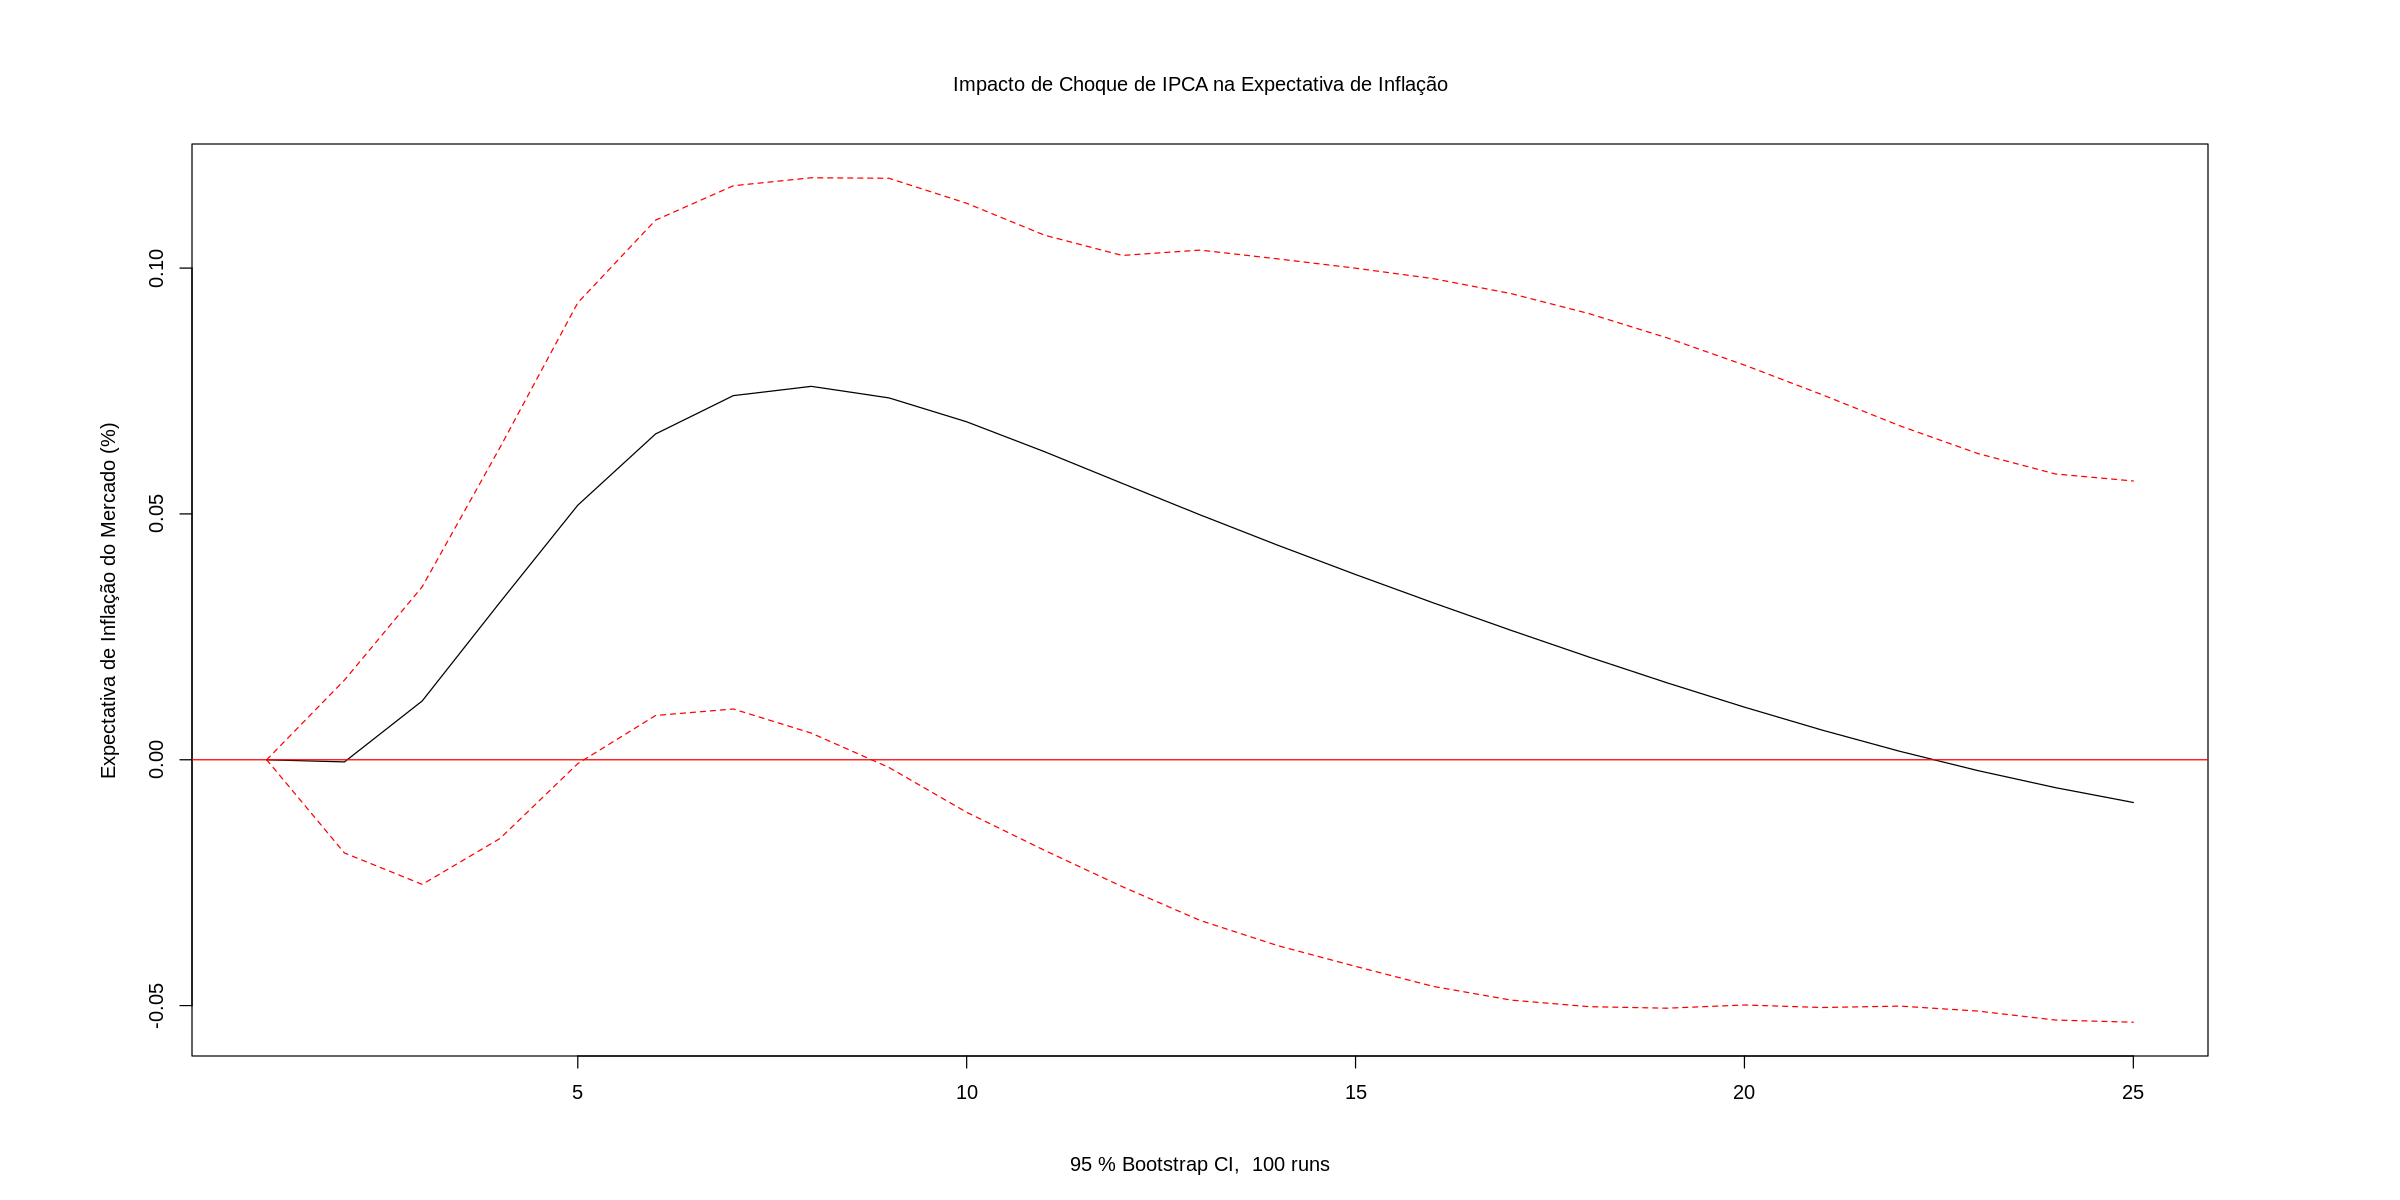

In [25]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Impulse Response Function
vecm_ipca_market_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_ipca_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "Impacto de Choque de IPCA na Expectativa de Inflação")

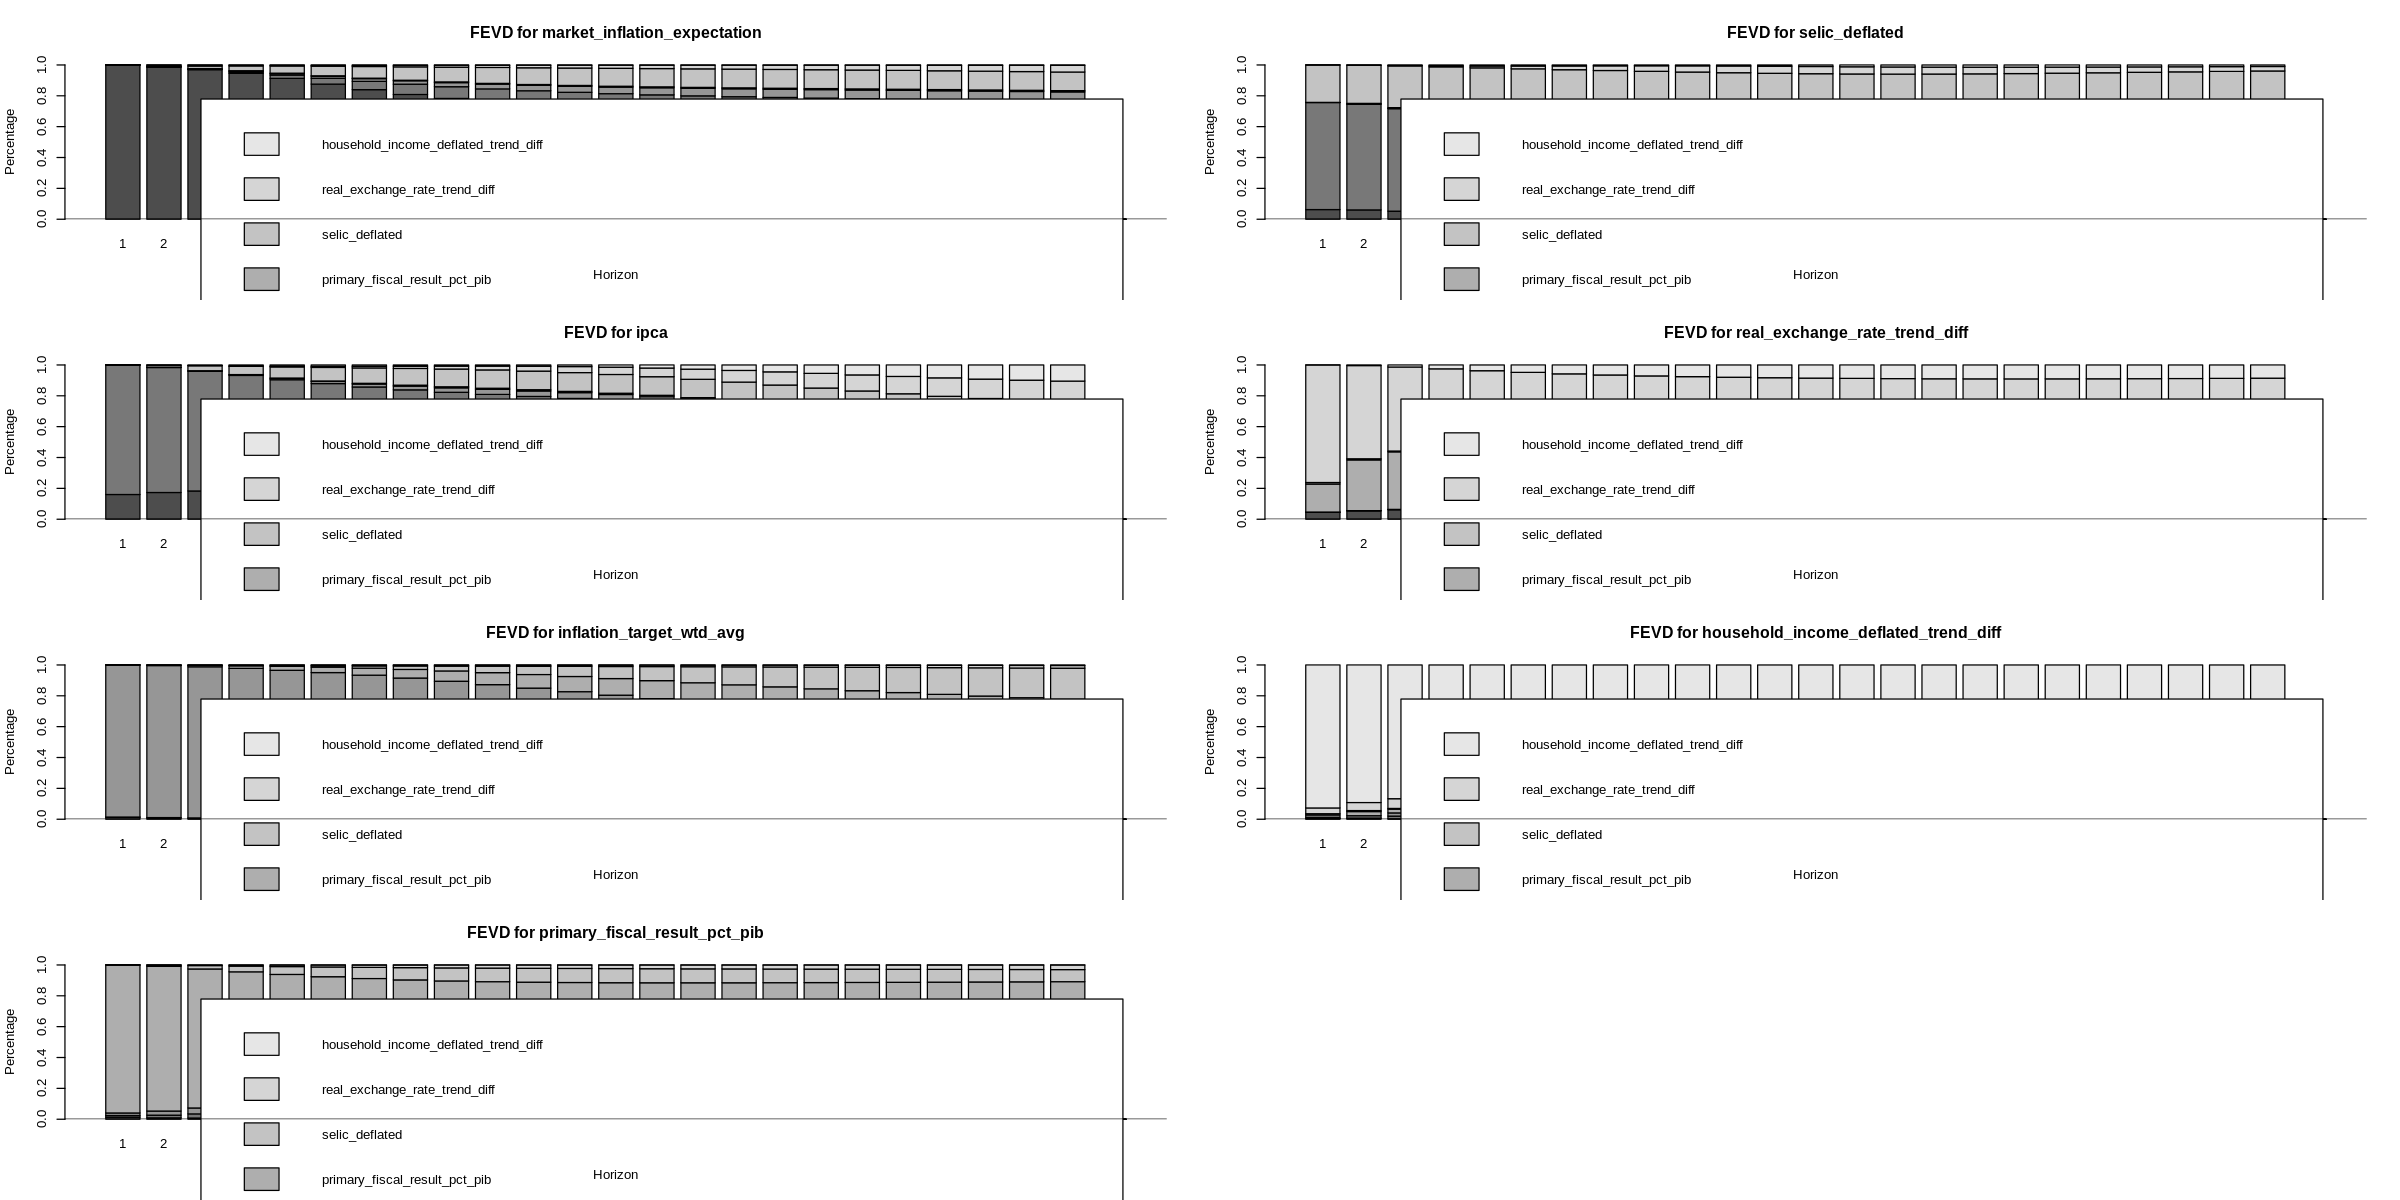

In [26]:
# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

plot(vecm_fevd)

**Resultado**

-

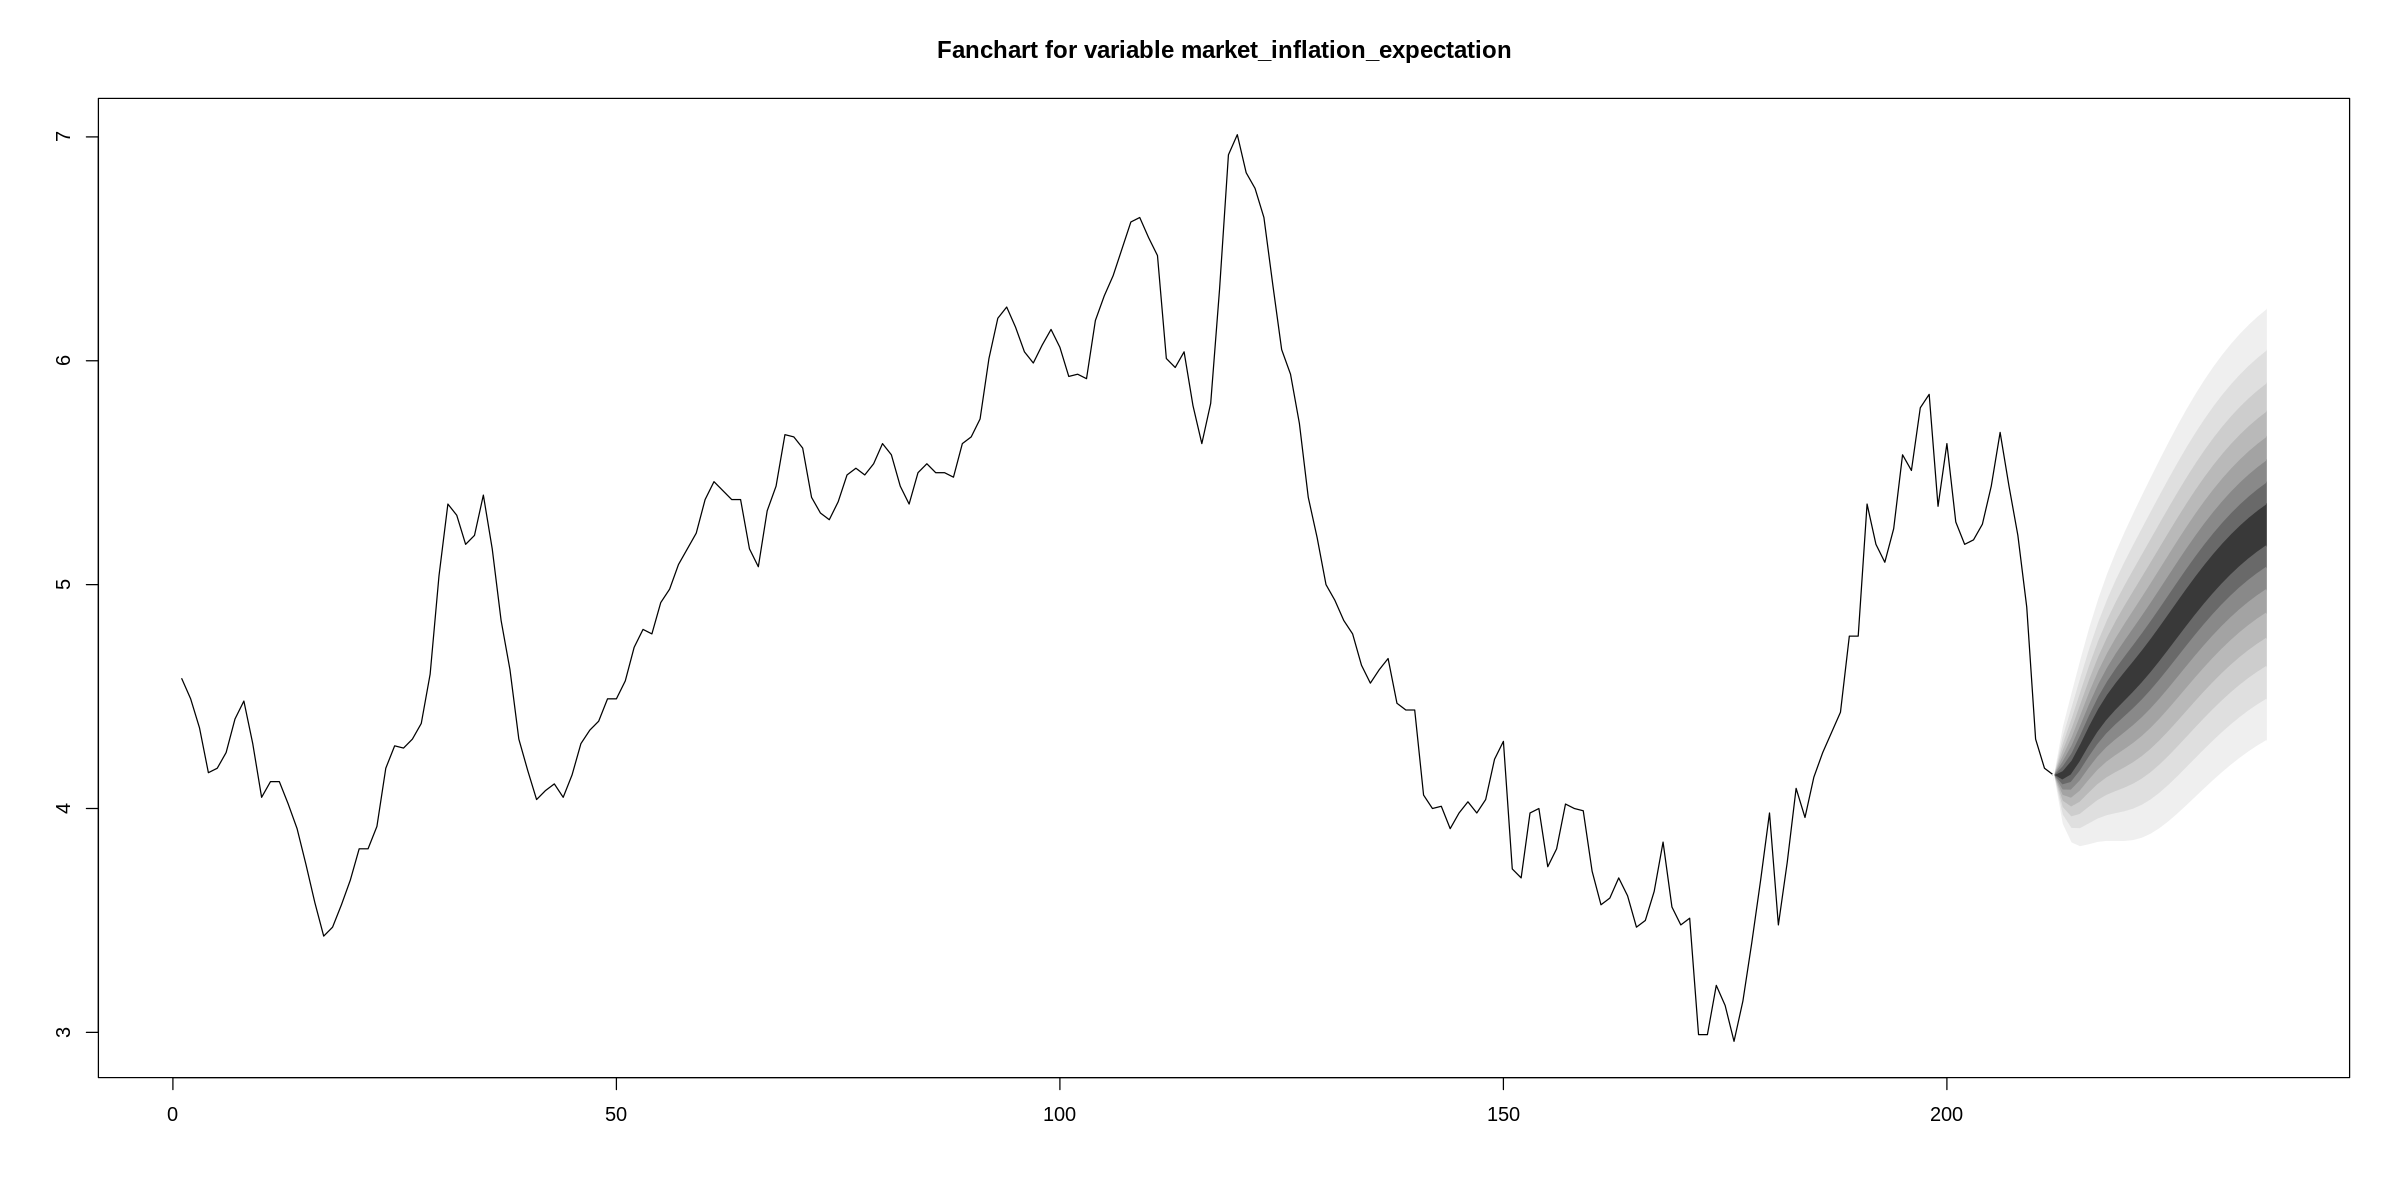

In [27]:
# Forecast using VECM
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

fanchart(forecast_vecm, names = "market_inflation_expectation")